# Plot convergence of distributions
This notebook takes you step by step trough the process of reproducing the convergence plots of the long term distributions of the QoI, which are presented in the paper. 

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### KS-distance

In [3]:
# define function to calculate KS-distance between two empirical distributions
def ks_dist(data1,data2):
    if np.ma.is_masked(data1):
        data1 = data1.compressed()
    if np.ma.is_masked(data2):
        data2 = data2.compressed()
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    if min(n1, n2) == 0:
        raise ValueError('Data passed to ks_dist must not be empty')

    # create an array with all the data
    data_all = np.concatenate([data1, data2])
    # create cdfs
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2

    cddiffs = np.abs(cdf1 - cdf2)

    # Identify the location of the statistic
    argmaxS = np.argmax(cddiffs)
    loc_maxS = data_all[argmaxS]
    d_1 = cddiffs[argmaxS]

    return d_1, loc_maxS

KS-distance: 0.557


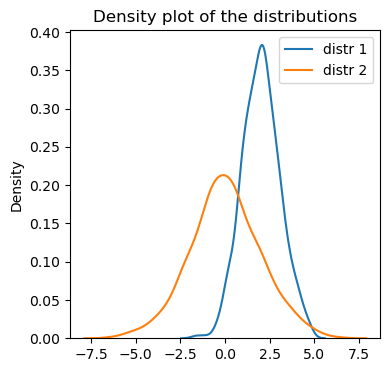

In [4]:
# a small example
data1 = np.random.normal(2,1,1000)
data2 = np.random.normal(0,2,1000)
plt.rcParams["figure.figsize"] = (4,4)
sns.kdeplot(data1)
sns.kdeplot(data2)
plt.legend(['distr 1','distr 2'])
plt.title("Density plot of the distributions")
print(f"KS-distance: {ks_dist(data1,data2)[0]}")

## Verify convergence of QoI distributions in HF sim
We first verify the convergence of the QoI distributions in the high fidelity simulation, by comparing the distributions over the first 10 000 days to the distributions over the full 20 000 days.

In [5]:
with h5py.File('./pre_computed_data/ref/HF_20000days_RK4.hdf5', 'r') as file:
    Q_HF = file['Q_HF'][:,:]
print(f"KS-distance E_[0,15]: {ks_dist(Q_HF[:100000,0],Q_HF[:200000,0])[0]:.3f}")
print(f"KS-distance Z_[0,15]: {ks_dist(Q_HF[:100000,1],Q_HF[:200000,1])[0]:.3f}")
print(f"KS-distance E_[16,21]: {ks_dist(Q_HF[:100000,2],Q_HF[:200000,2])[0]:.3f}")
print(f"KS-distance Z_[16,21]: {ks_dist(Q_HF[:100000,3],Q_HF[:200000,3])[0]:.3f}")

KS-distance E_[0,15]: 0.029
KS-distance Z_[0,15]: 0.023
KS-distance E_[16,21]: 0.009
KS-distance Z_[16,21]: 0.008


(0.029329999999999967, 0.00040608719338051225)


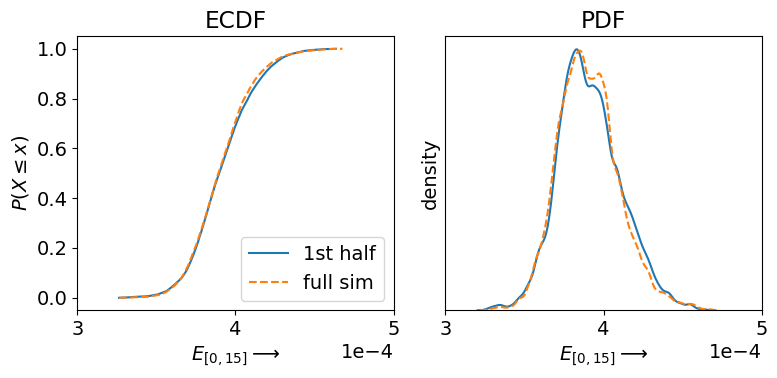

In [7]:
# make density plots for E_[0,15]
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams.update({'font.size': 14})
a = Q_HF[:100000,0]
b = Q_HF[:200000,0]

print(ks_dist(a,b))

# Cumulative distributions.
plt.subplot(1,2,1)
x = np.sort(a)
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label = "1st half")
x = np.sort(b)
y = np.arange(len(x))/float(len(x))
plt.plot(x, y,'--', label = "full sim")
#plt.vlines(ks_test_1D(a,b)[2],0.3,0.7,colors='grey')
plt.xlabel('$E_{[0,15]} \longrightarrow$')
plt.xticks([0.0003,0.0004,0.0005])
plt.xlim([0.0003,0.0005])
plt.title("ECDF")
plt.legend(loc='lower right')
plt.ylabel(r'$P(X \leq x)$')
plt.ticklabel_format(axis="both",style='sci',scilimits=(0,0),useMathText=False)

# Histograms.
plt.subplot(1,2,2)
sns.kdeplot(a, label = "1st half")
sns.kdeplot(b, linestyle='--',  label = "full sim")
plt.xlabel('$E_{[0,15]} \longrightarrow$')
plt.xticks([0.0003,0.0004,0.0005])
plt.xlim([0.0003,0.0005])
plt.yticks([])
plt.ylabel('density')
plt.title("PDF")
plt.ticklabel_format(axis="x",style='sci',scilimits=(0,0),useMathText=False)

plt.tight_layout()
#plt.savefig("figs/ecdf_pdf_E_015_DNS.pdf", bbox_inches='tight')

## Convergence of marginals for $\Delta Q$ in LF sim and QoI in HF sim
Next we compare the convergence rate of the distributions of the $\Delta Q_i$ in a LF sim which tracks a HF sim using the TO method and the convergence rate of the QoI distributions in a HF sim.

In [15]:
# to run the LF sim which tracks the HF sim for 20 000 days run:
from aux_code.read_inputs import adapt_input_file
adapt_input_file("inputs/in_LF_track_ref.json", "inputs/in_LF_track_ref_long.json", {"simulation_time":20000})
# and then in the terminal run: 
#    python LF_simulation.py inputs/in_LF_track_ref_long.json


0

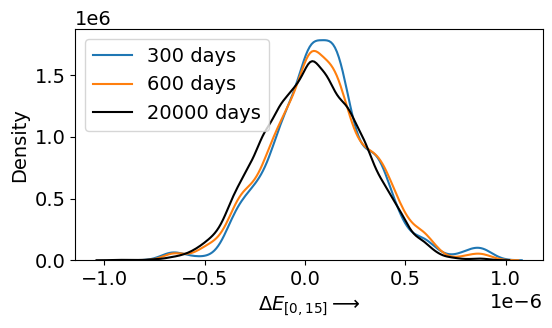

In [14]:
# let us for example visually inspect the convergence of the PDFs of dE_[0,15]
with h5py.File('pre_computed_data/train_data_TO/LF_track_ref_rk4_t_4000.0.hdf5', 'r') as file:
    dQ = file['dQ'][:,:]
plt.rcParams["figure.figsize"] = (5.75,3.5)
plt.rcParams.update({'font.size': 14})
spinnup  = 0
a = dQ[spinnup:spinnup+3000,0]
b = dQ[spinnup:spinnup+6000,0]
c = dQ[spinnup:spinnup+200000-1,0]

sns.kdeplot(a, label = "300 days")
sns.kdeplot(b,  label = "600 days")
sns.kdeplot(c,  label = "20000 days", color="black")
        
plt.legend(loc = "upper left")
plt.xlabel('$\Delta E_{[0,15]} \longrightarrow$')
plt.tight_layout()
#plt.savefig("figs_presentatie/PDF_dQ.png", dpi=700)

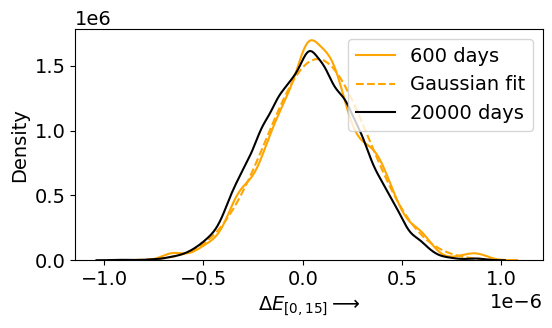

In [16]:
i = 0
plt.rcParams["figure.figsize"] = (5.75,3.5)
plt.rcParams.update({'font.size': 14})
a = dQ[spinnup:spinnup+6000,i]
sns.kdeplot(a,  label = "600 days", color="orange")
plt.legend(loc = "upper right")

b = dQ[spinnup:spinnup+6000:1,:]
Sigma = np.cov(b.T)
mean = b.mean(axis=0)
mean  = mean[i]
std = np.sqrt(Sigma[i,i])
distr = stats.norm(mean, std)

x = np.linspace(mean-4*std,mean+4*std,100)
plt.plot(x, distr.pdf(x), color="orange", linestyle="--", label="Gaussian fit")
#plt.ylim([0, 3.5*steps_per_day**7])
c = dQ[spinnup:spinnup+200000-1:1,i]
sns.kdeplot(c,  label = "20000 days", color="black")
plt.xlabel('$\Delta E_{[0,15]} \longrightarrow$')
plt.legend(loc = "upper right")
plt.tight_layout()
#plt.savefig("figs_presentatie/PDF_dQ+Gauss.png", dpi=700)

In [9]:
# define ugly plot function
def plot_conv_dQandQHF(dQ, Q_HF, dt_LF = 0.1, save_name = "none"):
    ## KS distance LES
    plt.rcParams.update({'font.size': 14})
    prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    print(prop_cycle)
    fig, axes = plt.subplot_mosaic("EFA;EFB;GHC;GHD", figsize=(12, 8))

    titles = [r"$E^{HF}_{[0,15]}$", r"$Z^{HF}_{[0,15]}$",r"$E^{HF}_{[16,21]}$", r"$Z^{HF}_{[16,21]}$"]
    plot_times = [3,6,12,25, 50,100, 200,400, 700, 1000, 1300, 2500,5000,10000, 19999]
    qoi_axes = ["E", "F", "G", "H"]

    steps_per_day = int(1/dt_LF)

    for i in range(4):
        divs = []
        for t in range(len(plot_times)-1):
            a = Q_HF[:plot_times[t]*steps_per_day,i]
            b = Q_HF[:plot_times[-1]*steps_per_day:1,i]
            divs = divs+ [ks_dist(a,b)[0]]
        axes[qoi_axes[i]].plot(plot_times[:-1],divs,'--',alpha = 0.5, label=titles[i])
        #plt.yscale("log")
        print(divs)

    axes["A"].set_prop_cycle(None)
    # convergence of dQ in LF solver 
    spinnup = 9

    titles = [r"$\Delta E_{[0,15]}$", r"$\Delta Z_{[0,15]}$",r"$\Delta E_{[16,21]}$", r"$\Delta Z_{[16,21]}$"]

    for i in range(4):
        divs = []
        for t in range(len(plot_times)-1):
            a = dQ[spinnup:spinnup+plot_times[t]*steps_per_day:1,i]
            b = dQ[spinnup:spinnup+plot_times[-1]*steps_per_day:1,i]
            divs = divs+ [ks_dist(b,a)[0]]
        axes[qoi_axes[i]].plot(plot_times[:-1],divs, label=titles[i])
        print(divs)

    for ax in qoi_axes:
        axes[ax].legend(loc='lower left')
        axes[ax].set_xscale("log")
        axes[ax].set_yscale("log")
        axes[ax].set_ylim([0.003,1.1])

        axes[ax].axhline(0.03, color='grey')
        axes[ax].annotate(r'KS-dist$ = 0.03$', xy=(2.5, 0.035), xycoords='data', size=10, ha='left', va='center')
        axes[ax].set_xticks([1,10,100,1000,10000])
        if ax in ["E","G"]:
            axes[ax].set_ylabel("KS-distance")
        else:
            axes[ax].set_yticklabels([])
        if ax in ["G","H"]:
            axes[ax].set_xlabel("days")
        else:
            axes[ax].set_xticklabels([])
        

    ## create sample density plots
    pdf_axes = ["A","B", "C", "D"]
    points_to_plot = [["dQ",0,50, 19999,"up"],["dQ",1,400,19999,"down"],["dQ",3,700, 19999,"up"],["Q_HF",3,700, 19999,"down"]] # give as [QoI, time mid, time end]
    for i in range(len(pdf_axes)):
        if points_to_plot[i][0] == "Q_HF":
            a = Q_HF[:points_to_plot[i][2]*steps_per_day,points_to_plot[i][1]]
            #b = file_ref["Q_HF"][points_to_plot[i][2]*1000:points_to_plot[i][3]*1000:10,points_to_plot[i][1]]/stds_HF[points_to_plot[i][1]]
            b = Q_HF[:points_to_plot[i][3]*steps_per_day,points_to_plot[i][1]]
        else:
            a = dQ[spinnup:spinnup+points_to_plot[i][2]*steps_per_day,points_to_plot[i][1]]
            #b = file_train_TO_4q["dQ"][spinnup+points_to_plot[i][2]*100:spinnup+points_to_plot[i][3]*100:1,points_to_plot[i][1]]/stds_LF[points_to_plot[i][1]]
            b = dQ[spinnup:spinnup+points_to_plot[i][3]*steps_per_day,points_to_plot[i][1]]

        d = ks_dist(a,b)[0]
        prop_id = 0 if points_to_plot[i][0] == "Q_HF" else 1
        sns.kdeplot(b, ax=axes[pdf_axes[i]], color="black")
        sns.kdeplot(a, ax=axes[pdf_axes[i]], color=prop_cycle[prop_id])
        
        axes[pdf_axes[i]].set_xticks([])
        axes[pdf_axes[i]].set_yticks([])
        axes[pdf_axes[i]].set_title(pdf_axes[i])
        axes[pdf_axes[i]].set_ylabel("")
        axes[pdf_axes[i]].legend(["20000 days",str(points_to_plot[i][2])+" days"], labelspacing = 0.1, loc = "upper right", fontsize = 10, handlelength=1)

        # annotations
        if points_to_plot[i][4] == "up":
            disp = 1.5
        else:
            disp = 0.5
        axes[qoi_axes[points_to_plot[i][1]]].annotate(
        pdf_axes[i],
        xy=(points_to_plot[i][2], d), xycoords='data',
        xytext=(points_to_plot[i][2], d*disp), textcoords='data',
        size=10,
        bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
        arrowprops=dict(arrowstyle="->"
                        ))
        plt.tight_layout()
        if not save_name == "none": plt.savefig(save_name, bbox_inches='tight')

We can now make the convergence plots which are presented in the paper.

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
[0.5392519625981299, 0.4814390719535977, 0.4041302065103255, 0.4041302065103255, 0.4046786339316967, 0.44454152707635386, 0.1554143207160359, 0.15368058402920143, 0.19796714835741785, 0.14180843042152108, 0.14460096081727164, 0.08807218960948049, 0.025400278013900657, 0.0293203145157257]
[0.5857892894644732, 0.5772888644432221, 0.3283164158207911, 0.3283164158207911, 0.3546706335316765, 0.36723546177308863, 0.16187281864093206, 0.17355864043202157, 0.22356937846892344, 0.15768366418320917, 0.14810594760507256, 0.10907986999349967, 0.016322589129456472, 0.02266016950847549]
[0.44458722936146805, 0.33069153457672884, 0.2640248679100622, 0.24669153457672882, 0.13584629231461573, 0.12446022301115055, 0.0901438321916096, 0.038805790289514475, 0.02746432321616088, 0.02668675433771689, 0.02246410782077568, 0.016584539226961348, 0.013939207960398048, 0.008515340767038415]
[0.398459922

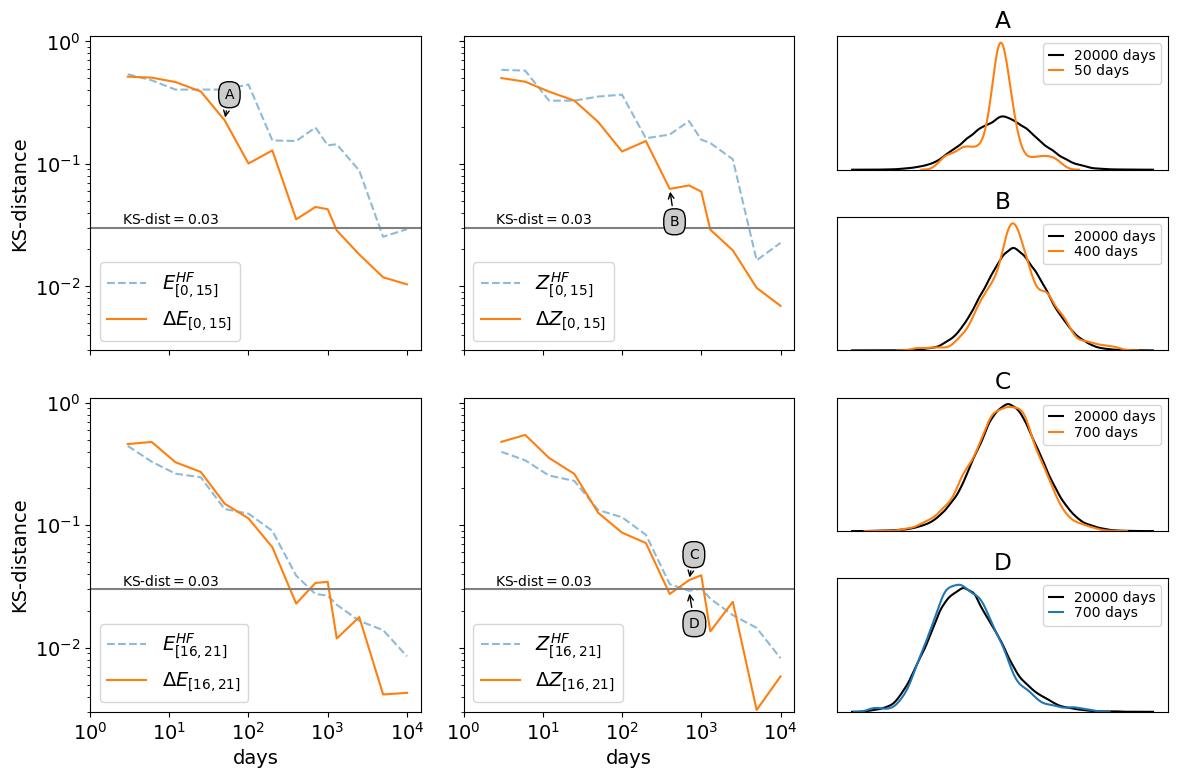

In [10]:
with h5py.File('./pre_computed_data/ref/HF_20000days_RK4.hdf5', 'r') as file:
    Q_HF = file['Q_HF'][:,:]
with h5py.File('./pre_computed_data/samples/LF_track_ref_rk4_t_20000.0.hdf5', 'r') as file:
    dQ = file['dQ'][:,:]

plot_conv_dQandQHF(dQ, Q_HF)